## Dynamic Traffic Assignments: DUO, DUE, DSO


WIP

There are 3 famous route choice principles for dynamic traffic assignments (DTA) (the definition varies depending on the terminology).

- Dynamic User Optimal (DUO): Travelers choose the shortest path based on the instantaneous travel time (the current average speed). 
- Dynamic User Equilibrium (DUE): Travelers choose the shortest path based on the actual travel time. 
- Dynamic System Optimal (DSO): Travelers choose the path so that the total travel time is minimized.

The important point of DTA is that travel time may change as the time progresses. 
Therefore, in the DUO, the chosen route may turn out not to be the actual shortest path after the traveler completes their trip, as the travel time may change during their trip.
Similarly, in the DUE, the "actual travel time" is unknown when the traveler choose the route, as it depends on the future travel time.
Likewise, in the DSO, it is not obvious which path minimizes the total travel time.

The default routing principle of UXsim is based on DUO, because it is reasonable and very easy to compute.

DUE and DSO are also important as theoretical benchmarks. 
Due to the aforementioned complexity, it is known that they are difficult to solve especially when the network is large. 
But, for small or mid scale networks with relatively small number of platoons, their approximate solutions can be obtained by UXsim. 
The solvers for DTA problems are implemented as `uxsim.DTAsolvers` submodule.
In this notebook, we demonstrate their behaviors.

Techical notes for experienced readers.
In this demonstration, we consider the route choice problem only. In the other words, we do not consider the departure time problem, and the departure time of each traveler is assumed to be fixed.


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from pylab import *
import uxsim
from uxsim.DTAsolvers import *

### Two route network with parallel highway and arterial

We simulate a simple toy network with a route choice option. In order to use the identical scenario in multiple simulations efficiently, we define the following function that setup a World object with the identical conditions.

In [2]:

# scenario definition
def create_World():
    """
    A function that returns World object with scenario informaiton. This is faster way to reuse the same scenario, as `World.copy` or `World.load_scenario` takes some computation time.
    """
    W = uxsim.World(
        name="",
        deltan=20,
        tmax=6000,
        print_mode=0, save_mode=1, show_mode=1,
        vehicle_logging_timestep_interval=1, 
        hard_deterministic_mode=False,
        random_seed=42
    )

    W.addNode("1", 0, 1)
    W.addNode("2", 1, 1)
    W.addNode("3", 5, 1)
    W.addNode("4", 0, 0)
    W.addNode("5", 1, 0)
    W.addNode("6", 5, 0)
    W.addNode("7", 6, 0.5)

    W.addLink("highway12", "1", "2", length=1000, number_of_lanes=1, merge_priority=1)
    W.addLink("highway23", "2", "3", length=3000, number_of_lanes=1, merge_priority=1, capacity_out=0.6)
    W.addLink("highway37", "3", "7", length=1000, number_of_lanes=1, merge_priority=1)
    W.addLink("onramp", "5", "2", length=1000, number_of_lanes=1, merge_priority=0.5)
    W.addLink("arterial45", "4", "5", length=1000, free_flow_speed=10, number_of_lanes=2, merge_priority=0.5)
    W.addLink("arterial56", "5", "6", length=3000, free_flow_speed=10, number_of_lanes=2, merge_priority=0.5)
    W.addLink("arterial67", "6", "7", length=1000, free_flow_speed=10, number_of_lanes=2, merge_priority=0.5)

    W.adddemand("1", "7", 0, 3000, 0.3)
    W.adddemand("4", "7", 0, 3000, 0.4*3)

    return W

The network structure is as follows. Vehicles travel from nodes "1" and "4" at the left to node "7" at the right. The upper route is a *highway*, and the bottom is an *arterial road*. The highway has faster maximum speed but smaller traffic capacity compared with the arterial road. 
Vehicles from "3" can choose either highway or arterial, depending on the traffic condition. 

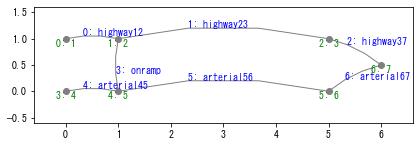

In [3]:
W = create_World()
W.show_network()

Furthermore, we define the following visualization function to visualize simulation results.

In [4]:
def visualizaion_helper_function(W):
    W.analyzer.print_simple_stats(force_print=True)
    W.analyzer.network_average()

    r1 = W.defRoute(["arterial45", "onramp", "highway23", "highway37"])
    r2 = W.defRoute(["arterial45", "arterial56", "arterial67"])

    W.analyzer.time_space_diagram_traj_links(r1.links)
    W.analyzer.time_space_diagram_traj_links(r2.links)

    ttt = np.linspace(0, W.TIME, W.TSIZE)
    tt1 = [r1.actual_travel_time(t) for t in ttt]
    tt2 = [r2.actual_travel_time(t) for t in ttt]

    fig, ax1 = subplots()
    ax1.plot(ttt, tt1, "--", label="r1", lw=1)
    ax1.plot(ttt, tt2, "--", label="r2", lw=1)
    ax1.set_xlabel("t")
    ax1.set_ylabel("travel time")
    ax1.grid()
    ax2 = ax1.twinx()
    ax2.set_ylabel("cumlative count")
    ax2.plot(ttt, W.get_link("onramp").cum_arrival, "-", label="highway (r1)")
    ax2.plot(ttt, W.get_link("arterial56").cum_arrival, "-", label="arterial (r2)")
    ax1.legend(loc="upper center", bbox_to_anchor=(0.1, 1.25), ncol=1)
    ax2.legend(loc="upper center", bbox_to_anchor=(0.9, 1.25), ncol=1)
    show()

#### DUO

DUO can be simulated by the default procedure of UXsim as follows.

results:
 average speed:	 9.2 m/s
 number of completed trips:	 4500 / 4500
 average travel time of trips:	 897.6 s
 average delay of trips:	 567.6 s
 delay ratio:			 0.632
 total distance traveled:	 23580000.0 m
results:
 average speed:	 9.2 m/s
 number of completed trips:	 4500 / 4500
 average travel time of trips:	 897.6 s
 average delay of trips:	 567.6 s
 delay ratio:			 0.632
 total distance traveled:	 23580000.0 m


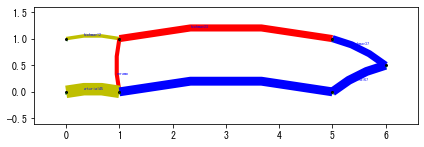

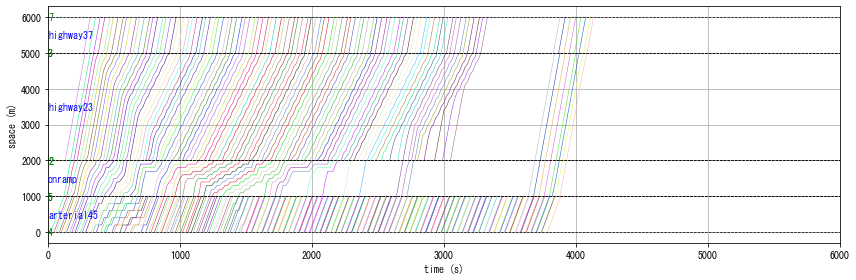

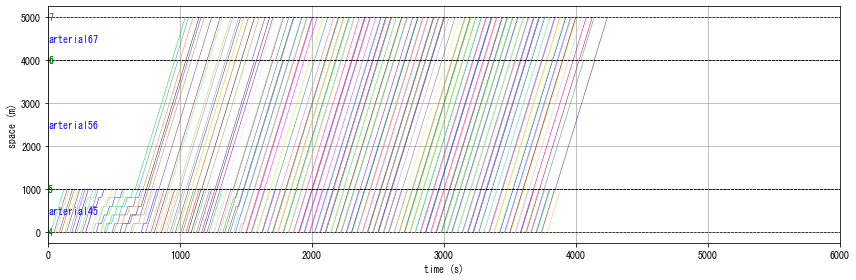

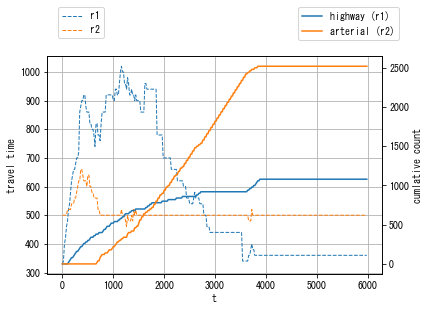

In [5]:
# DUO (default)

W_DUO = create_World()
W_DUO.exec_simulation()
W_DUO.analyzer.print_simple_stats(force_print=True)
df_DUO = W_DUO.analyzer.basic_to_pandas()

visualizaion_helper_function(W_DUO)

In DUO, you can see that many vehicles chose the highway route at the early stage of the simulation due to the fast maximum speed. It then caused a significant traffic jam, resulting a longer travel time. This demonstrates the myopic nature of DUO routing principle.

#### DUE

In [11]:
# DUE
solver_DUE = SolverDUE(create_World)
solver_DUE.solve(max_iter=100, print_progress=False)
W_DUE = solver_DUE.W_sol
W_DUE.analyzer.print_simple_stats(force_print=True)
df_DUE = W_DUE.analyzer.basic_to_pandas()

solving DUE...
DUE summary:
 total travel time: initial 4039200.0 -> average of last 12 runs 3166766.7
 number of potential route changes: initial 79.0 -> average of last 12 runs 65.7
 travel time gap: initial 13080.0 -> average of last 12 runs 4218.3
results:
 average speed:	 10.5 m/s
 number of completed trips:	 4500 / 4500
 average travel time of trips:	 734.2 s
 average delay of trips:	 404.2 s
 delay ratio:			 0.551
 total distance traveled:	 23940000.0 m


results:
 average speed:	 10.5 m/s
 number of completed trips:	 4500 / 4500
 average travel time of trips:	 734.2 s
 average delay of trips:	 404.2 s
 delay ratio:			 0.551
 total distance traveled:	 23940000.0 m


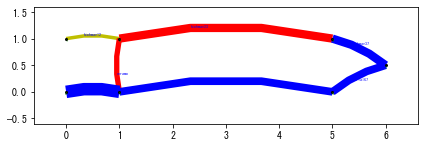

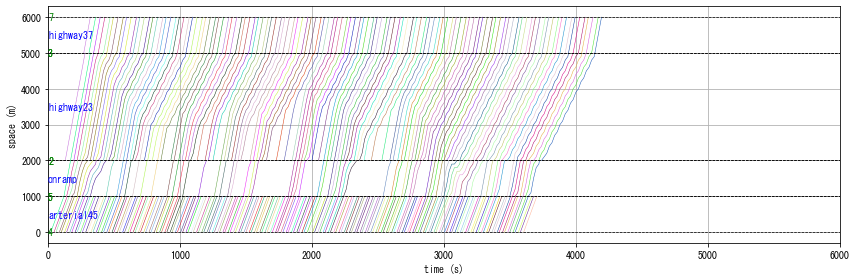

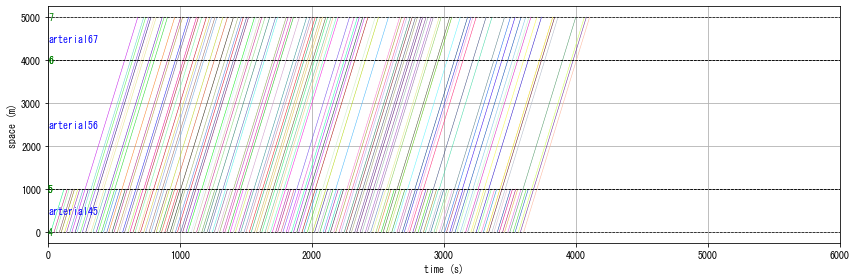

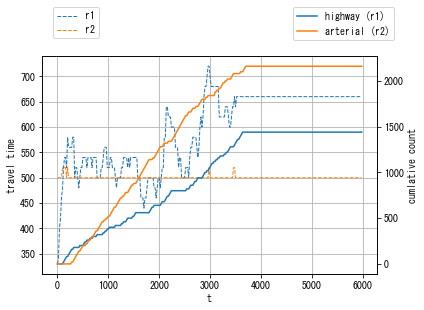

In [12]:
visualizaion_helper_function(W_DUE)

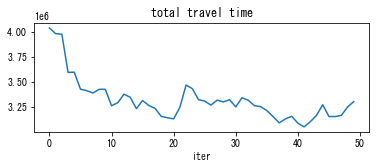

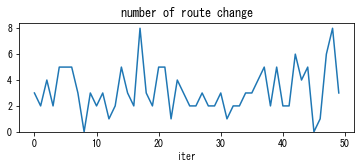

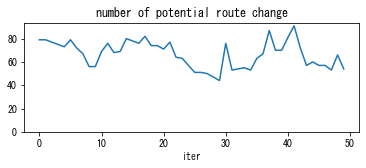

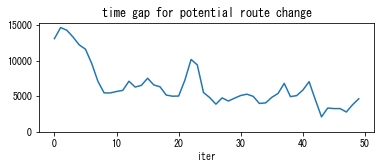

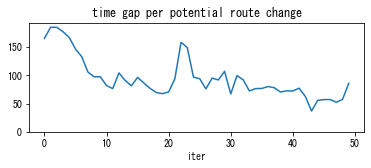

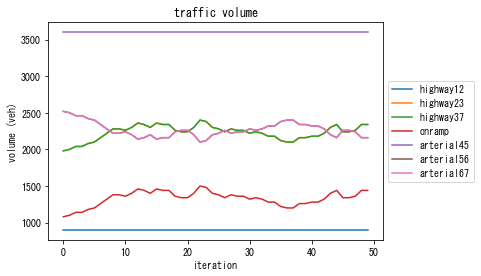

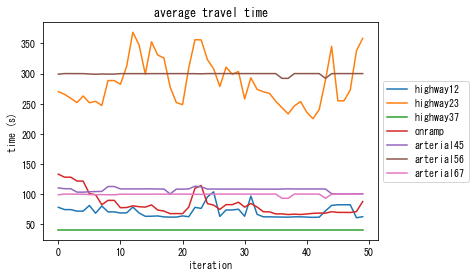

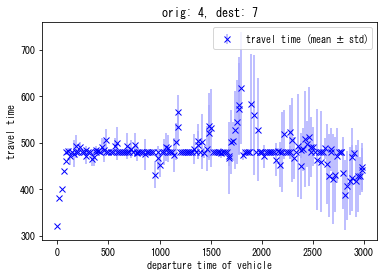

In [13]:
solver_DUE.plot_convergence()
solver_DUE.plot_link_stats()
solver_DUE.plot_vehicle_stats(orig="4", dest="7")

#### DSO

In [14]:
# DSO
solver_DSO = SolverDSO(create_World)
solver_DSO.solve(max_iter=100, print_progress=False, initial_solution_World=W_DUE)
W_DSO = solver_DSO.W_sol
W_DSO.analyzer.print_simple_stats(force_print=True)
df_DSO = W_DSO.analyzer.basic_to_pandas()



solving DSO...
DSO summary:
 total travel time: initial 3304000.0 -> last 2965600.0
results:
 average speed:	 11.9 m/s
 number of completed trips:	 4500 / 4500
 average travel time of trips:	 659.0 s
 average delay of trips:	 329.0 s
 delay ratio:			 0.499
 total distance traveled:	 23580000.0 m


results:
 average speed:	 11.9 m/s
 number of completed trips:	 4500 / 4500
 average travel time of trips:	 659.0 s
 average delay of trips:	 329.0 s
 delay ratio:			 0.499
 total distance traveled:	 23580000.0 m


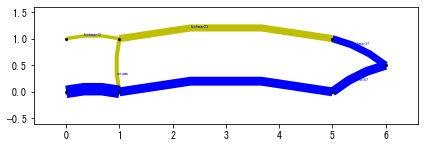

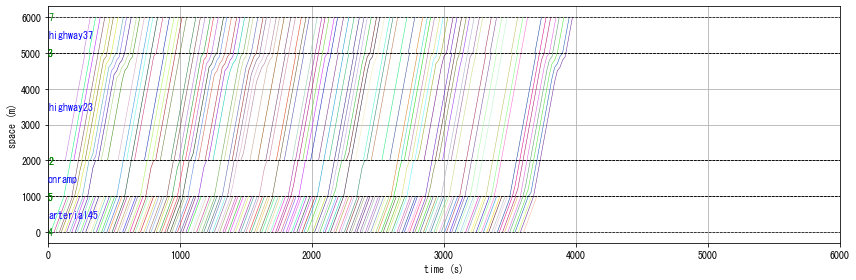

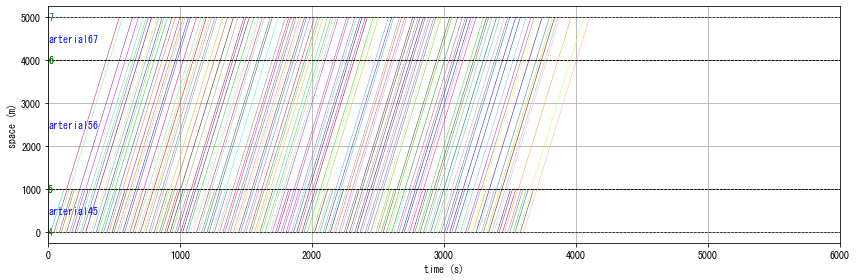

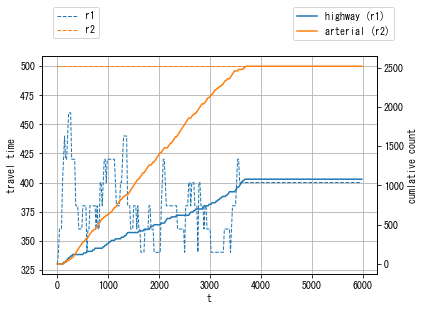

In [15]:

visualizaion_helper_function(W_DSO)

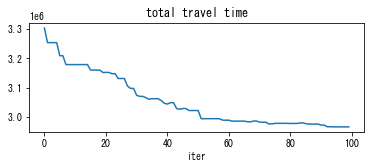

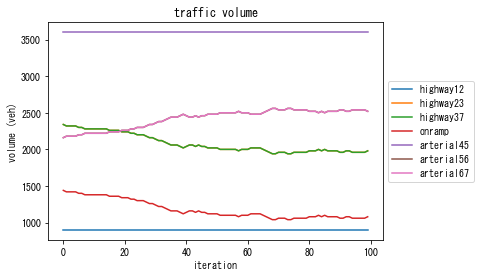

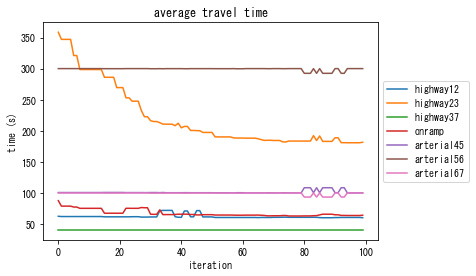

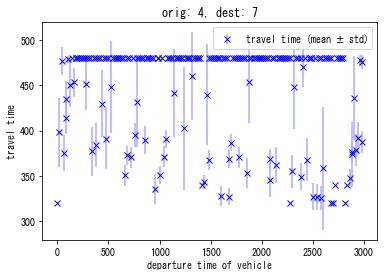

In [16]:

solver_DSO.plot_convergence()
solver_DSO.plot_link_stats()
solver_DSO.plot_vehicle_stats(orig="4", dest="7")

#### DSO by Genetic Algorithm

Alternative solution method. This may be more practical than the above theoretical method, depending on the conditions.

In [23]:
# DSO by GA
solver_DSO_GA = SolverDSO_GA(create_World)
solver_DSO_GA.solve(max_iter=50, print_progress=False, pop_size=20)
W_DSO_GA = solver_DSO_GA.W_sol
W_DSO_GA.analyzer.print_simple_stats(force_print=True)
df_DSO_GA = W_DSO_GA.analyzer.basic_to_pandas()


solving DSO by GA...
DSO summary:
 total travel time: initial 3267200.0 -> last 2957600.0
results:
 average speed:	 12.0 m/s
 number of completed trips:	 4500 / 4500
 average travel time of trips:	 657.2 s
 average delay of trips:	 327.2 s
 delay ratio:			 0.498
 total distance traveled:	 23640000.0 m


results:
 average speed:	 12.0 m/s
 number of completed trips:	 4500 / 4500
 average travel time of trips:	 657.2 s
 average delay of trips:	 327.2 s
 delay ratio:			 0.498
 total distance traveled:	 23640000.0 m


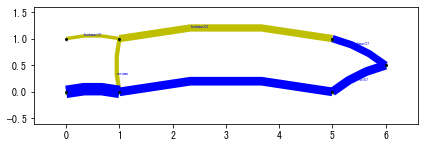

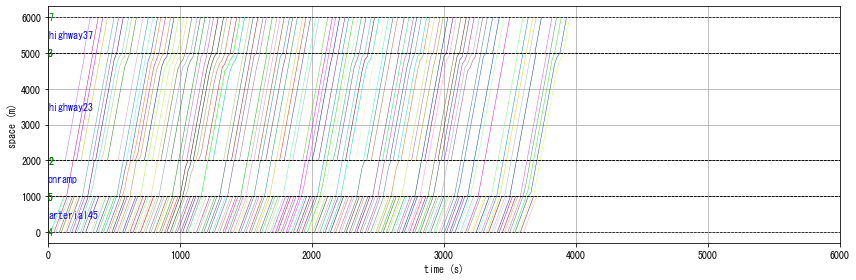

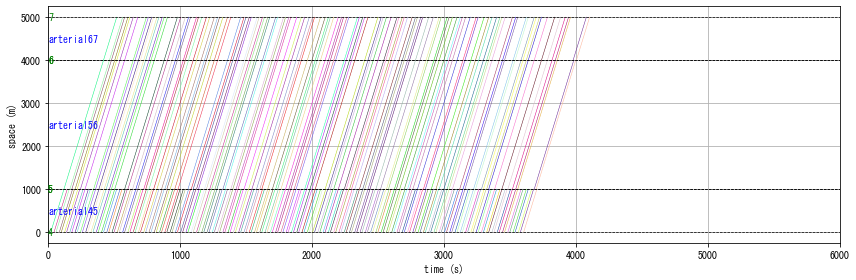

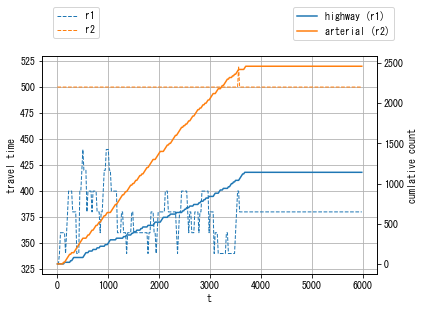

In [24]:
visualizaion_helper_function(W_DSO_GA)

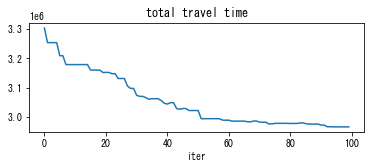

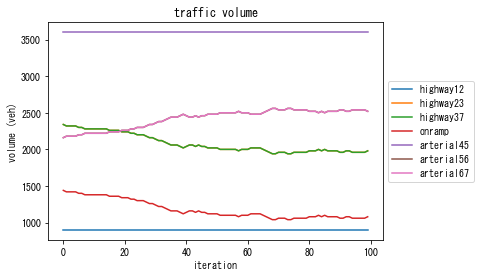

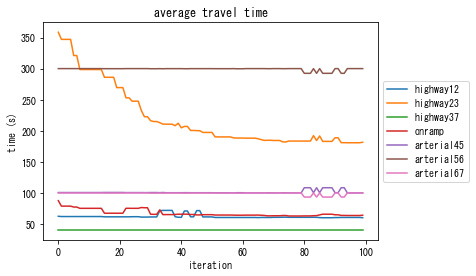

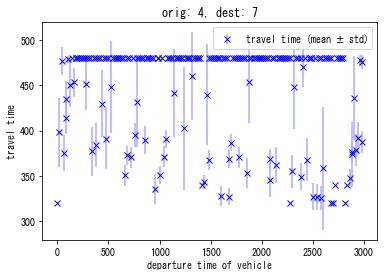

In [25]:
solver_DSO.plot_convergence()
solver_DSO.plot_link_stats()
solver_DSO.plot_vehicle_stats(orig="4", dest="7")

#### Comparison

Comparison of 3 cases.

In [26]:

print("DUO")
display(df_DUO)
print("DUE")
display(df_DUE)
print("DSO")
display(df_DSO)
print("DSO by GA")
display(df_DSO_GA)


DUO


,total_trips,completed_trips,total_travel_time,average_travel_time,total_delay,average_delay
0,4500,4500,4039200.0,897.6,2554200.0,567.6


DUE


,total_trips,completed_trips,total_travel_time,average_travel_time,total_delay,average_delay
0,4500,4500,3304000.0,734.222222,1819000.0,404.222222


DSO


,total_trips,completed_trips,total_travel_time,average_travel_time,total_delay,average_delay
0,4500,4500,2965600.0,659.022222,1480600.0,329.022222


DSO by GA


,total_trips,completed_trips,total_travel_time,average_travel_time,total_delay,average_delay
0,4500,4500,2957600.0,657.244444,1472600.0,327.244444


### SF network

In [ ]:

# scenario definition
def create_World():
    W = uxsim.World(
        name="",
        deltan=10,
        tmax=9600,
        print_mode=0, save_mode=0, show_mode=1,
        random_seed=0
    )

    W.load_scenario("dat/sfnetwork.uxsim_scenario")
    W.finalize_scenario()

    return W

results:
 average speed:	 5.7 m/s
 number of completed trips:	 32210 / 32210
 average travel time of trips:	 1704.0 s
 average delay of trips:	 316.5 s
 delay ratio:			 0.186
 total distance traveled:	 309190000.0 m


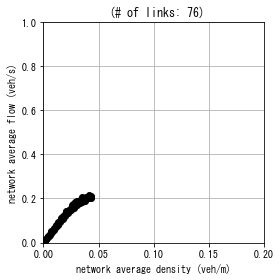

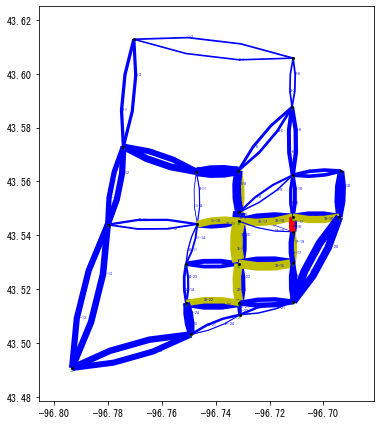

In [34]:
# DUO

W_DUO = create_World()

W_DUO.exec_simulation()

W_DUO.analyzer.print_simple_stats(force_print=True)
W_DUO.analyzer.macroscopic_fundamental_diagram()
W_DUO.analyzer.network_average()

 DATA SOURCE AND LICENCE : Sioux Falls network. This is based on https://github.com/bstabler/TransportationNetworks/tree/master/SiouxFalls by Transportation Networks for Research Core Team. Users need to follow their licence. Especially, this data is for academic research purposes only, and users must indicate the source of any dataset they are using in any publication that relies on any of the datasets provided in this web site.
simulation setting:
 scenario name: 
 simulation duration:	 9600 s
 number of vehicles:	 32210 veh
 total road length:	 314000.0 m
 time discret. width:	 10 s
 platoon size:		 10 veh
 number of timesteps:	 960
 number of platoons:	 3221
 number of links:	 76
 number of nodes:	 24
 setup time:		 0.15 s
number of OD pairs: 576, number of routes: 2076
solving DUE...
 DATA SOURCE AND LICENCE : Sioux Falls network. This is based on https://github.com/bstabler/TransportationNetworks/tree/master/SiouxFalls by Transportation Networks for Research Core Team. Users need

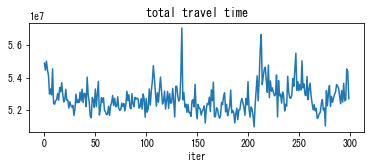

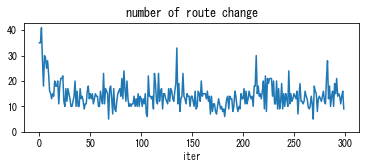

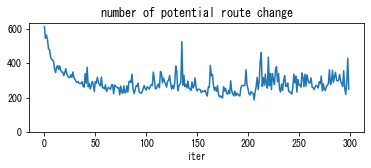

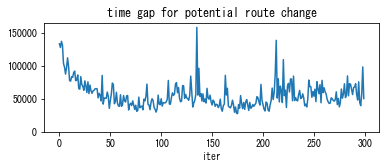

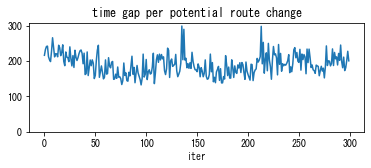

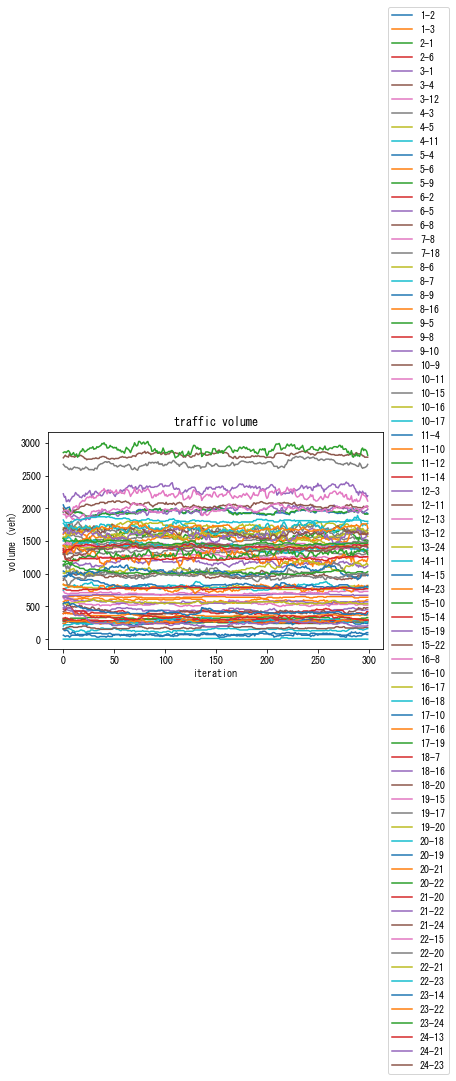

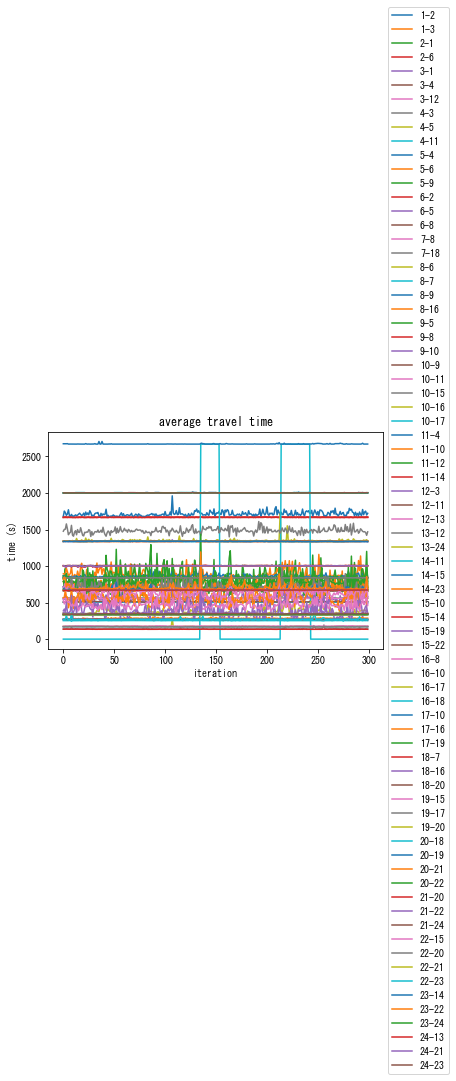

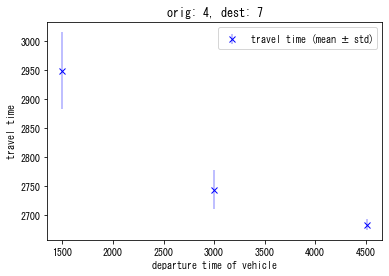

results:
 average speed:	 5.9 m/s
 number of completed trips:	 32210 / 32210
 average travel time of trips:	 1636.4 s
 average delay of trips:	 249.0 s
 delay ratio:			 0.152
 total distance traveled:	 305890000.0 m


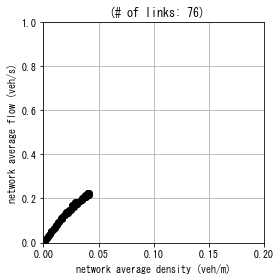

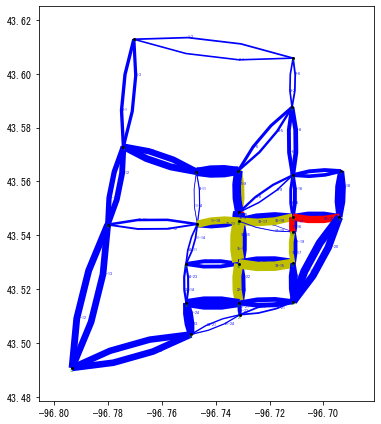

In [29]:
#DUE


solver_DUE = SolverDUE(create_World)
solver_DUE.solve(max_iter=300)
W_DUE = solver_DUE.W_sol


In [ ]:

solver_DUE.plot_convergence()
solver_DUE.plot_link_stats()
solver_DUE.plot_vehicle_stats(orig="4", dest="7")

routes = enumerate_k_random_routes(W, k=5)
o, d = "13", "10"
print(f"{o}-{d}: # of routes: {len(routes[o,d])}, min # of links: {min([len(r) for r in routes[o,d]])}")
solver_DUE.plot_vehicle_stats(orig=o, dest=d)
o, d = "10", "13"
print(f"{o}-{d}: # of routes: {len(routes[o,d])}, min # of links: {min([len(r) for r in routes[o,d]])}")
solver_DUE.plot_vehicle_stats(orig=o, dest=d)
o, d = "20", "10"
print(f"{o}-{d}: # of routes: {len(routes[o,d])}, min # of links: {min([len(r) for r in routes[o,d]])}")
solver_DUE.plot_vehicle_stats(orig=o, dest=d)
o, d = "10", "20"
print(f"{o}-{d}: # of routes: {len(routes[o,d])}, min # of links: {min([len(r) for r in routes[o,d]])}")
solver_DUE.plot_vehicle_stats(orig=o, dest=d)

W_DUE.analyzer.print_simple_stats(force_print=True)
W_DUE.analyzer.macroscopic_fundamental_diagram()
W_DUE.analyzer.network_average()


In [ ]:
#DSO

solver_DSO = SolverDSO(create_World)
solver_DSO.solve(max_iter=300, initial_solution_World=W_DUE)
W_DSO = solver_DSO.W_sol

In [ ]:
solver_DSO.plot_convergence()
solver_DSO.plot_link_stats()
solver_DSO.plot_vehicle_stats(orig="4", dest="7")

routes = enumerate_k_random_routes(W, k=5)
o, d = "13", "10"
print(f"{o}-{d}: # of routes: {len(routes[o,d])}, min # of links: {min([len(r) for r in routes[o,d]])}")
solver_DSO.plot_vehicle_stats(orig=o, dest=d)
o, d = "10", "13"
print(f"{o}-{d}: # of routes: {len(routes[o,d])}, min # of links: {min([len(r) for r in routes[o,d]])}")
solver_DSO.plot_vehicle_stats(orig=o, dest=d)
o, d = "20", "10"
print(f"{o}-{d}: # of routes: {len(routes[o,d])}, min # of links: {min([len(r) for r in routes[o,d]])}")
solver_DSO.plot_vehicle_stats(orig=o, dest=d)
o, d = "10", "20"
print(f"{o}-{d}: # of routes: {len(routes[o,d])}, min # of links: {min([len(r) for r in routes[o,d]])}")
solver_DSO.plot_vehicle_stats(orig=o, dest=d)

W_DSO.analyzer.print_simple_stats(force_print=True)
W_DSO.analyzer.macroscopic_fundamental_diagram()
W_DSO.analyzer.network_average()


In [ ]:
#DSO GA

solver_DSO_GA = SolverDSO_GA(create_World)
solver_DSO_GA.solve(max_iter=300, initial_solution_World=W_DUE)
W_DSO = solver_DSO_GA.W_sol

In [ ]:

solver_DSO_GA.plot_convergence()
solver_DSO_GA.plot_link_stats()
solver_DSO_GA.plot_vehicle_stats(orig="4", dest="7")

routes = enumerate_k_random_routes(W, k=5)
o, d = "13", "10"
print(f"{o}-{d}: # of routes: {len(routes[o,d])}, min # of links: {min([len(r) for r in routes[o,d]])}")
solver_DSO_GA.plot_vehicle_stats(orig=o, dest=d)
o, d = "10", "13"
print(f"{o}-{d}: # of routes: {len(routes[o,d])}, min # of links: {min([len(r) for r in routes[o,d]])}")
solver_DSO_GA.plot_vehicle_stats(orig=o, dest=d)
o, d = "20", "10"
print(f"{o}-{d}: # of routes: {len(routes[o,d])}, min # of links: {min([len(r) for r in routes[o,d]])}")
solver_DSO_GA.plot_vehicle_stats(orig=o, dest=d)
o, d = "10", "20"
print(f"{o}-{d}: # of routes: {len(routes[o,d])}, min # of links: {min([len(r) for r in routes[o,d]])}")
solver_DSO_GA.plot_vehicle_stats(orig=o, dest=d)

W_DSO.analyzer.print_simple_stats(force_print=True)
W_DSO.analyzer.macroscopic_fundamental_diagram()
W_DSO.analyzer.network_average()
